In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Unknown instance spec: Please select VM configuration

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.stats import levy
from scipy import optimize
from scipy import stats
import numpy as np

In [2]:
data = np.genfromtxt('Levi.csv', delimiter=',', skip_header=1)

In [3]:
data = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/Levi.csv", sep=",", header=None)

In [4]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000,10001
0,0.195734,6.124834,1.814294,4.195780,1.335033,35.256986,389.872022,8.360853,6.361410,112.010443,188.056311,5.740908,125.187090,28.145230,31.592908,3.922248,1.925820,1.778586e+01,31.849540,52.699505,107.873813,2.526947,529.009650,1221.093890,16.563977,67.939785,1.088500,177.022942,8.916619,2.179755,7.620000,1.456103,2837.312091,15.813652,2.607248,987.568447,4.348256,2.596144e+01,8.539917,445.020980,...,5.954425,51.793621,9.019084,26.432772,157.813604,1.858515,180.953380,1.392571,5.668533,80.592986,4.044770,13.022126,6.372115,14.354617,174.419667,3.417805,6.274735,3.298876,20.980722,71.572526,52.704721,128.623393,2607.536974,86.287063,9.777556,3.920778,5.617955,1.528911e+01,88.639970,15.950741,65.899029,8.843636,13.137668,1.536911,33.830222,18.820968,56.692981,184.890849,3176.414172,55.920298
1,0.267592,9.569729,2.453735,18.379047,142.912695,36.478879,192.003139,124.345128,14.386317,34.140625,33.253438,11841.955970,56.725507,736.444558,17.144448,12.785073,11.531026,2.262127e+02,9.756303,789.794935,43.583060,67.935201,9758.149136,15.080857,146.719694,225.794229,18.596120,24.417666,44.518630,7.718701,12.947910,41.785509,5.555426,4548.231018,95.455367,15.325166,54.825323,2.015373e+03,35.042245,1153.371429,...,7.359561,11.508944,2.180184,6362.663833,2234.827678,857.017967,411.240542,3.705809,160.701453,6.851605,5.294004,32.646963,412.280260,262.077820,19.926974,252.104842,51.799449,104.903180,7848.256170,3.432304,3.340185,40.780995,6.122756,5.671227,10.109567,11.351288,18.852647,6.678612e+06,5.060710,16.665647,23.582553,140.038935,1583.951807,36.549855,15.759218,51.822498,122.229993,1530.752067,3.587223,519.460160
2,0.240074,2.289752,1.822040,609.158835,0.908843,1.764996,62.087574,3.454377,3.178423,88.698418,50.063936,1.057552,0.798765,1.169772,9.276870,5.838547,3.447887,5.682643e+01,1.185939,12.043041,3.615164,7.643632,1.258839,4.633146,5778.218427,3.546638,705.496474,135.083510,21.825683,0.875642,0.540738,1.553525,1.419482,3.591341,4.823064,0.865495,1.444958,2.107010e+01,1.012178,15.736106,...,17.136156,60.273765,1.517697,8.111293,4.950034,32.080955,11.117645,2.221668,1.918984,0.634026,29.217614,0.858624,996.022540,27.391394,1.023654,18.061560,2.580358,22.555217,5.233726,1110.232173,3.240236,300.806106,13.902797,1.121623,1.747558,49.085705,7.728389,2.525296e+00,1.879231,1.105204,1.354872,1.609253,1.999567,3.252398,6.730155,6.309863,376.902915,1.405985,2.337624,5.864544
3,0.081150,0.439113,0.313752,0.569169,0.206079,2.202286,2.765618,4.715335,0.254852,1.333834,8.347533,0.388563,0.211799,8.735707,4.697714,8.986876,0.370119,2.990498e+01,3.410018,3.928342,0.398181,5.230569,35.182237,13.400354,0.461011,0.539932,126.854249,0.606307,0.682445,0.481545,13.103481,4591.021593,0.847627,2.874947,30.947773,1.179024,4.762530,7.645794e-01,1.467587,3.763654,...,3.537816,0.411584,0.225933,0.505396,0.415134,268.753406,0.354589,0.243973,0.318224,1362.636525,0.341986,621.114693,8.151575,0.139127,0.305602,23.196697,2.911492,0.367134,35.238081,17.659702,12.966888,0.289155,22.832238,0.194313,0.150337,1.540284,1.638772,6.973591e-01,2.066491,1.276504,1.434085,42.991403,4.069231,170.264949,0.791717,0.631800,0.259342,0.817527,13.761219,2.935589
4,0.108861,4.338036,3.406876,21.361749,2.643845,7455.951813,14.018750,50.996829,41.734901,23.120234,43.675807,0.764963,0.822369,4.866476,291.577083,11.225316,2.368174,1.822411e+02,62.154921,5.405011,1.918532,0.768538,5.522000,23.648337,1.864419,1.259326,486.065224,31.548969,1.182761,265.523979,5.384356,2.679399,8.006832,4.235176,58.704473,21.508304,79.191120,3.927944e+01,76.416299,1.388532,...,8.504221,6.834030,55.599888,10.965559,4.676790,0.567944,11.454749,134.458543,26.977723,6.977521,25.067958,121.8937

<Axes: >

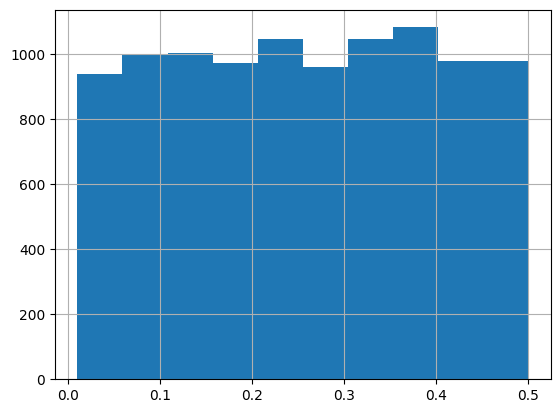

In [5]:
data[0].hist()

In [12]:
n, Size = data.shape
train = data[:int(n*0.8), :]
test = data[int(n*0.8):, :]
test = test[test[:, 0].argsort()]

In [4]:
train_X = train[:, 2:]
train_Y = train[:, 0:2]
test_X = test[:, 2:]
test_Y = test[:, 0:2]

In [19]:
SEED = 42
train_intervals_df, test_intervals_df = train_test_split(data, train_size=0.8, random_state=SEED, shuffle=True)

In [20]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [31]:
train_intervals_X = np.array(train_intervals_df)[:, 2:]
train_intervals_Y = np.array(train_intervals_df)[:, :2]
test_intervals_X = np.array(test_intervals_df)[:, 2:]
test_intervals_Y = np.array(test_intervals_df)[:, :2]
val_intervals_X = np.array(val_intervals_df)[:, 2:]
val_intervals_Y = np.array(val_intervals_df)[:, :2]

In [32]:
def estimate_parameters_lsq(sample):
    sample_sorted = np.sort(sample)
    ecdf = np.arange(1, len(sample) + 1) / len(sample)
    
    def levy_cdf(x, mu, c):
        mask = x > mu
        result = np.zeros_like(x, dtype=float)
        result[mask] = erfc(np.sqrt(c / (2 * (x[mask] - mu))))
        return result

    def error_function(params, x, ecdf_values):
        mu, c = params
        # Ограничения на параметры
        if c <= 0 or mu >= np.min(x):
            return 1e10  # Большое значение как штраф
        theoretical_cdf = levy_cdf(x, mu, c)
        return np.sum((theoretical_cdf - ecdf_values)**2)
    

    mu_init = np.median(sample) - 1
    c_init = 1 / (2 * np.mean(1 / (sample - mu_init)))

    result = optimize.minimize(
        error_function,
        [mu_init, c_init],
        args=(sample_sorted, ecdf),
        bounds=[(None, np.min(sample)), (1e-10, None)]  # μ < min(sample), c > 0
    )
    return result.x

In [49]:
mnk = np.zeros((2000,2))
#mnk = np.zeros((test_Y.shape[0], test_Y.shape[1]))
for i, sample in enumerate(train_intervals_X[:1,:]):
    print(i, sample)
    mnk[i, 0], mnk[i, 1] = estimate_parameters_lsq(sample)

0 [   5.65524834   16.38446556 1045.02201008 ...    9.77449204   43.11994163
   16.86819798]


In [53]:
estimate_parameters_lsq(train_intervals_X[:1,:][0])

array([0.21038512, 4.47865456])

In [52]:
train_intervals_X[:1,:][0]

array([   5.65524834,   16.38446556, 1045.02201008, ...,    9.77449204,
         43.11994163,   16.86819798])

In [ ]:
estimate_parameters_lsq(sample)

In [45]:
test_intervals_Y

array([[0.01782188, 8.79359208],
       [0.0242569 , 0.54997602],
       [0.48379959, 6.12997544],
       ...,
       [0.29846591, 4.92457023],
       [0.15526261, 6.69304157],
       [0.36997174, 0.12844057]])

In [43]:
mnk

array([[0.21038512, 4.47865456],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

### Метод моментов

In [7]:
MM = np.zeros((data[:,0:2].shape))
for i in range(data.shape[0]):

    sample_mean = np.mean(data[i, 2:])
    sample_var = np.var(data[i, 2:])
    
    # E[X] = μ + ∞ (mean doesn't exist)
    # Mode = μ + c/(3)
    # Median = μ + c/(2*erfc^(-1)(1/2))^2
    
    mu_estimate = np.min(data[i, 2:])
    
    # Using sample median to estimate c
    sample_median = np.median(data[i, 2:])
    c_estimate = 2 * (sample_median - mu_estimate) * (0.4769360141)**2  # 0.4769... is erfc^(-1)(1/2)
    
    MM[i][0] = mu_estimate  # location parameter
    MM[i][1] = c_estimate   # scale parameter

In [8]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((data[:,0] - MM[:,0]) / data[:,0])) * 100
r2 = r2_score(data[:,0], MM[:,0])
mse = mean_squared_error(data[:,0], MM[:,0])
rmse = np.sqrt(mean_squared_error(data[:,0], MM[:,0]))
print("\nMM par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((data[:,1] - MM[:,1]) / data[:,1])) * 100
r2 = r2_score(data[:,1], MM[:,1])
mse = mean_squared_error(data[:,1], MM[:,1])
rmse = np.sqrt(mean_squared_error(data[:,1], MM[:,1]))
print("\nMM par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


MM par 1
MSE: 0.13657865594101376
RMSE: 0.3695654961451539
R² Score: -5.940090592214592
MAPE: 244.51052708967086%

MM par 2
MSE: 0.04533847369794732
RMSE: 0.2129283299562257
R² Score: 0.9943806504677055
MAPE: 3.0957922564073357%


### Регрессия на интервалах

In [5]:
levi_inter = CatBoostRegressor(loss_function='MultiRMSE')
levi_inter.fit(train_X, train_Y, eval_set = (test_X, test_Y))

0:	learn: 2.8006857	test: 2.8133639	best: 2.8133639 (0)	total: 3.61s	remaining: 1h 8s
1:	learn: 2.7604332	test: 2.7757807	best: 2.7757807 (1)	total: 7.51s	remaining: 1h 2m 26s
2:	learn: 2.7201252	test: 2.7382909	best: 2.7382909 (2)	total: 10.6s	remaining: 58m 55s
3:	learn: 2.6813190	test: 2.7020417	best: 2.7020417 (3)	total: 15.2s	remaining: 1h 2m 59s
4:	learn: 2.6434837	test: 2.6660646	best: 2.6660646 (4)	total: 19.1s	remaining: 1h 3m 21s
5:	learn: 2.6056775	test: 2.6298442	best: 2.6298442 (5)	total: 22.8s	remaining: 1h 2m 48s
6:	learn: 2.5692056	test: 2.5952608	best: 2.5952608 (6)	total: 26.4s	remaining: 1h 2m 26s
7:	learn: 2.5330889	test: 2.5620252	best: 2.5620252 (7)	total: 29.4s	remaining: 1h 45s
8:	learn: 2.4982244	test: 2.5289010	best: 2.5289010 (8)	total: 32.5s	remaining: 59m 41s
9:	learn: 2.4628851	test: 2.4952184	best: 2.4952184 (9)	total: 35.7s	remaining: 58m 52s
10:	learn: 2.4298047	test: 2.4642107	best: 2.4642107 (10)	total: 38.8s	remaining: 58m 4s
11:	learn: 2.3968966	tes

In [6]:
Cat_predictions = levi_inter.predict(test_X)

In [7]:
levi_inter.save_model('levi_inter_model.cbm')

In [8]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nInter par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nInter par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Inter par 1
MSE: 0.01892495510248613
RMSE: 0.1375680017390895
R² Score: 0.03217243036151274
MAPE: 128.98097281555056%

Inter par 2
MSE: 0.22281295809615154
RMSE: 0.47203067495254114
R² Score: 0.972502378285808
MAPE: 11.692778756861525%


### Регрессия на статистиках

In [9]:
stat_M = np.zeros((7999,10)) # Матрицы для записиси статистик наблюдений
test_stat_M = np.zeros((2000,10))

In [10]:
#Далее для каждого наблюдения вычисляются 4 статистики
stat_M[:,0] = np.mean(train_X, axis=1) # Вычисляется среднее 
stat_M[:,1] = np.var(train_X, axis=1) # Вычисляется дисперсию 
stat_M[:,2] = np.std(train_X, axis=1) # Вычисляется стандартное отклонение
stat_M[:,3] =  stat_M[:,2] / stat_M[:,0] # Вычисляется вариацию 

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
for i, q in enumerate(quantiles):
    stat_M[:, 4 + i] = np.quantile(train_X, q, axis=1)

In [12]:
test_stat_M[:,0] = np.mean(test_X, axis=1)
test_stat_M[:,1] = np.var(test_X, axis=1)
test_stat_M[:,2] = np.std(test_X, axis=1)
test_stat_M[:,3] =  test_stat_M[:,2] / test_stat_M[:,0]

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
for i, q in enumerate(quantiles):
    test_stat_M[:, 4 + i] = np.quantile(test_X, q, axis=1)

In [13]:
levi_stat = CatBoostRegressor(iterations=10000,
                          learning_rate=0.05,
                          depth=5, loss_function='MultiRMSE')
levi_stat.fit(stat_M, train_Y, eval_set = (test_stat_M, test_Y))

0:	learn: 2.7095922	test: 2.7195194	best: 2.7195194 (0)	total: 4.68ms	remaining: 46.9s
1:	learn: 2.5835958	test: 2.5933709	best: 2.5933709 (1)	total: 6.04ms	remaining: 30.2s
2:	learn: 2.4615528	test: 2.4711904	best: 2.4711904 (2)	total: 7.08ms	remaining: 23.6s
3:	learn: 2.3467639	test: 2.3572619	best: 2.3572619 (3)	total: 8.31ms	remaining: 20.8s
4:	learn: 2.2365086	test: 2.2468901	best: 2.2468901 (4)	total: 10.1ms	remaining: 20.2s
5:	learn: 2.1328534	test: 2.1439657	best: 2.1439657 (5)	total: 11.1ms	remaining: 18.4s
6:	learn: 2.0329577	test: 2.0436853	best: 2.0436853 (6)	total: 12.1ms	remaining: 17.2s
7:	learn: 1.9374916	test: 1.9482353	best: 1.9482353 (7)	total: 13.2ms	remaining: 16.4s
8:	learn: 1.8464719	test: 1.8569279	best: 1.8569279 (8)	total: 14.2ms	remaining: 15.7s
9:	learn: 1.7628216	test: 1.7727951	best: 1.7727951 (9)	total: 15.2ms	remaining: 15.2s
10:	learn: 1.6813817	test: 1.6912525	best: 1.6912525 (10)	total: 16.2ms	remaining: 14.7s
11:	learn: 1.6030774	test: 1.6122281	best

In [14]:
levi_stat.save_model('levi_stat_model.cbm')

In [15]:
Cat_predictions = levi_stat.predict(test_stat_M)

In [16]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nStat par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nStat par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Stat par 1
MSE: 0.002918994976646465
RMSE: 0.054027724148315415
R² Score: 0.8507217692863337
MAPE: 35.60102725520652%

Stat par 2
MSE: 0.01897408771649355
RMSE: 0.13774646172041424
R² Score: 0.9976583844545752
MAPE: 2.460846031999258%


### Регрессия на моментах

In [32]:
train_m_X = train_X.copy()
for i in range(train_X.shape[0]):
    for j in range(1, train_X.shape[1]):
        train_m_X[i,j] += train_m_X[i,j-1]

test_m_X = test_X.copy()
for i in range(test_X.shape[0]):
    for j in range(1, test_X.shape[1]):
        test_m_X[i,j] += test_m_X[i,j-1]

In [35]:
levi_m = CatBoostRegressor(loss_function='MultiRMSE')
levi_m.fit(train_m_X, train_Y, eval_set = (test_m_X, test_Y))

0:	learn: 2.8057587	test: 2.8160290	best: 2.8160290 (0)	total: 4.97s	remaining: 1h 22m 41s
1:	learn: 2.7702886	test: 2.7821220	best: 2.7821220 (1)	total: 9.25s	remaining: 1h 16m 55s
2:	learn: 2.7372010	test: 2.7483584	best: 2.7483584 (2)	total: 13.8s	remaining: 1h 16m 32s
3:	learn: 2.7071477	test: 2.7185944	best: 2.7185944 (3)	total: 17.6s	remaining: 1h 13m 13s
4:	learn: 2.6782361	test: 2.6897429	best: 2.6897429 (4)	total: 22.1s	remaining: 1h 13m 16s
5:	learn: 2.6498068	test: 2.6616866	best: 2.6616866 (5)	total: 25.6s	remaining: 1h 10m 38s
6:	learn: 2.6223712	test: 2.6356455	best: 2.6356455 (6)	total: 29s	remaining: 1h 8m 34s
7:	learn: 2.5948256	test: 2.6095091	best: 2.6095091 (7)	total: 33s	remaining: 1h 8m 11s
8:	learn: 2.5679912	test: 2.5838005	best: 2.5838005 (8)	total: 37.6s	remaining: 1h 9m 4s
9:	learn: 2.5433693	test: 2.5591654	best: 2.5591654 (9)	total: 42.1s	remaining: 1h 9m 25s
10:	learn: 2.5184324	test: 2.5352418	best: 2.5352418 (10)	total: 46.6s	remaining: 1h 9m 50s
11:	lea

In [36]:
Cat_predictions = levi_m.predict(test_X)

In [37]:
levi_m.save_model('levi_moment_model.cbm')

In [38]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nMoment par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nMoment par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Moment par 1
MSE: 0.020544429628884617
RMSE: 0.14333328165113857
R² Score: -0.05064795607997419
MAPE: 146.86311020125964%

Moment par 2
MSE: 33.24831874015692
RMSE: 5.766135511775362
R² Score: -3.1032159851097463
MAPE: 91.9380406460652%
